In [1]:
import numpy as np
import random
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from plot_functions import *
from utilities import * 

# For autoreloading the imported moduls
%load_ext autoreload
%autoreload 2
device = 'cpu'


In [2]:
#load the original data
ihdp_train = np.load("data/IHDP/ihdp_npci_1-1000.train.npz")
device = 'cpu'

#Preprocessing so that the fourth variable in the data set is transformed to categorical
import copy
def transform_x_data(x_data):
    new_x_data = copy.deepcopy(x_data)
    #Transform the 4th variable into a categorical variable
    vals_4th_var = np.unique(x_data[:,3,:])
    val_to_idx = dict(zip(vals_4th_var, range(len(vals_4th_var))))
    vfunc = np.vectorize(lambda x: val_to_idx[x])
    new_x_data[:,3,:] = vfunc(new_x_data[:,3,:])
    
    #Transform 14th variable to regular {0,1} representation
    new_x_data[:,13,:] = new_x_data[:,13,:]-1
    
    return new_x_data
    
ihdp_x_train = transform_x_data(ihdp_train['x'])

# check the distribution of the original dataset


In [5]:
#Check what are the variable distributions like
ycf = ihdp_train['ycf'][:,0]
yf = ihdp_train['yf'][:,0]
x = ihdp_train['x'][:,:,0]
t = ihdp_train['t'][:,0]


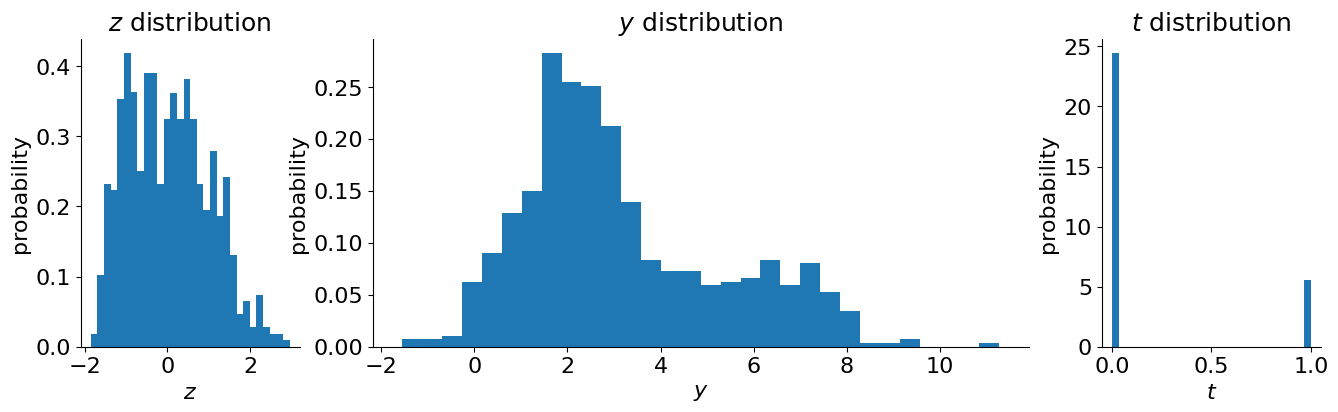

In [6]:
fig, ax = plt.subplots(1,3, figsize=(16,4),gridspec_kw={"width_ratios":[1,3,1]})



ax[0].hist(x[:, 5], bins=30, density=True)
ax[0].set_title("$z$ distribution", fontsize=18)
ax[0].set_xlabel('$z$', fontsize=16)
ax[0].set_ylabel("probability", fontsize=16)
ax[0].tick_params(which='major', axis='both', labelsize=16)

ax[1].hist(yf, bins=30, density=True)
ax[1].set_title("$y$ distribution", fontsize=18)
ax[1].set_xlabel('$y$', fontsize=16)
ax[1].set_ylabel("probability", fontsize=16)
ax[1].tick_params(which='major', axis='both', labelsize=16)

ax[2].hist(t, bins=30, density=True)
ax[2].set_title("$t$ distribution", fontsize=18)
ax[2].set_xlabel('$t$', fontsize=16)
ax[2].set_ylabel("probability", fontsize=16)
ax[2].tick_params(which='major', axis='both', labelsize=16)

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

#plt.tight_layout()
plt.show()

# Train a VAE to generate samples

Epoch 0:
Epoch loss: 581.3679635184152
x: 580.2183721633185, kld: 1.1495975837821053
Epoch 1:
Epoch loss: 551.5678187779018
x: 547.9616612025669, kld: 3.6061632292611256
Epoch 2:
Epoch loss: 535.9226379394531
x: 510.75257364908856, kld: 25.17006392706008
Epoch 3:
Epoch loss: 529.4870038713727
x: 503.31949143182663, kld: 26.167511985415505
Epoch 4:
Epoch loss: 539.1675066266741
x: 513.1441737583706, kld: 26.023330552237375
Epoch 5:
Epoch loss: 536.7527204241071
x: 513.1651030040923, kld: 23.58762059892927
Epoch 6:
Epoch loss: 530.5466599237351
x: 499.45235043480284, kld: 31.094314484369185
Epoch 7:
Epoch loss: 527.9151800246466
x: 501.40310959588913, kld: 26.512072699410574
Epoch 8:
Epoch loss: 524.8826700846354
x: 492.60243733723956, kld: 32.28022847856794
Epoch 9:
Epoch loss: 527.4770013718378
x: 491.9214521135603, kld: 35.555557977585565
Epoch 10:
Epoch loss: 525.6801060267857
x: 492.40646216982884, kld: 33.27364394778297
Epoch 11:
Epoch loss: 518.8194856189546
x: 485.9917675199963, 

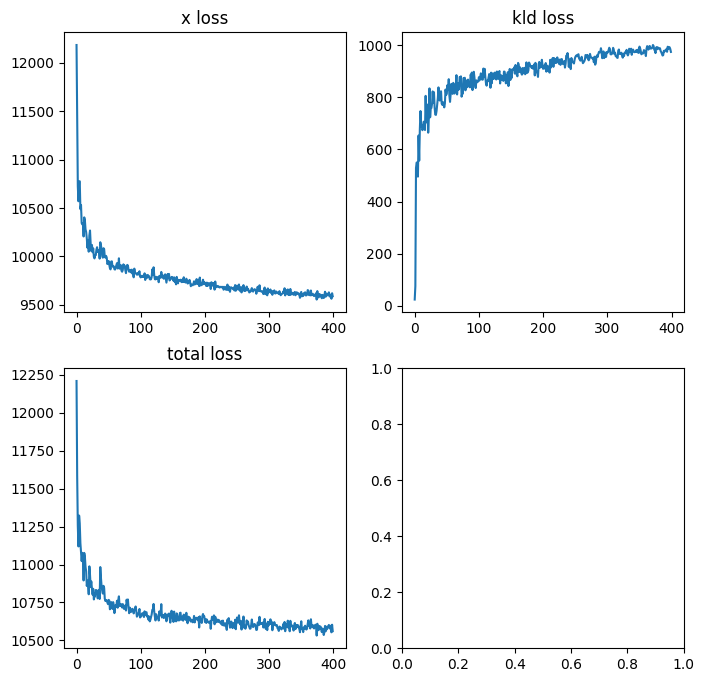

In [ ]:
from datagenVAE import GenericDataset, train_datagenerator, savemodel, loadmodel, trainZtoTmodel, dataGeneratorVAE, FullyConnected, DataLoader
dataset = GenericDataset(ihdp_x_train[:,:,0])
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)
device='cpu'
plot_curves=False
print_logs=True
num_epochs=400
lr_start=0.02
lr_end=0.001
x_dim=ihdp_x_train.shape[1]
z_dim=1
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)
#Remove the following comments to run
proxymodel, losses = train_datagenerator(device, plot_curves, print_logs,
              dataloader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30, x_mode=x_mode)
savemodel(proxymodel, "proxygenerator(zdim="+str(z_dim)+")")

# Generate data by pretrained models

## Load the pretrained generative models

In [8]:
from datagenVAE import GenericDataset, train_datagenerator, savemodel, loadmodel, trainZtoTmodel, dataGeneratorVAE, FullyConnected
x_dim=x.shape[1]
z_dim=1
device='cpu'
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)
proxymodel = loadmodel(name="proxygenerator(zdim=1)", modeltype=dataGeneratorVAE, args=[x_dim, z_dim, device, 3, 30, 3, 30, x_mode])
model_zt = loadmodel("ztotgenerator", modeltype=FullyConnected, args=[[1]+[10]*3+[1]])

## Generte data 

In [9]:

from datagenVAE import generatedata
from cevaetools import create_dfs_datasets
main_folder = "ihdpdata_latent_z"
sub_folder = "ATE1samplesize20000times10"
ATE = 1
zvar_index = 0
dataparameters = [20000, proxymodel, model_zt, ATE, zvar_index]
generate_df = generatedata
param_times=30

In [10]:
dfs, datasets = create_dfs_datasets(generate_df, [dataparameters], param_times=10, repeat=True, 
                    main_folder=main_folder, sub_folder=sub_folder, labels=["df20000"])

Creation of the directory './data/ihdpdata_latent_z/ATE1samplesize20000times10/ failed. Trying to empty the same folder.


# Load the generated data

In [11]:
main_folder = "ihdpdata_latent_z"
sub_folder = "ATE1samplesize20000times10"
param_times=30

dfs, datasets = load_dfs(main_folder, sub_folder, param_times)
data = dfs['df20000'][1]

In [12]:
data.head()

,z,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x17,x18,x19,x20,x21,x22,x23,x24,t,y
0,-1.516679,-1.839084,-2.072765,1.932956,3.0,1.577237,-0.196407,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.046114
1,-0.609076,-0.095691,-0.751511,0.309298,1.0,-0.511399,-0.243863,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.520743
2,-1.009557,-1.131535,-1.805418,1.136011,2.0,-2.217895,0.517258,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.606356
3,0.327537,0.878671,0.307031,0.383081,1.0,0.008484,-0.130389,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.997720
4,-0.478286,-0.161013,0.200456,0.478705,1.0,-0.385228,-1.257398,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.132903


In [13]:
z = data['z']
t = data['t']
y = data['y']
y_t0 = data.loc[data['t']==0, 'y']
y_t1 = data.loc[data['t']==1, 'y']

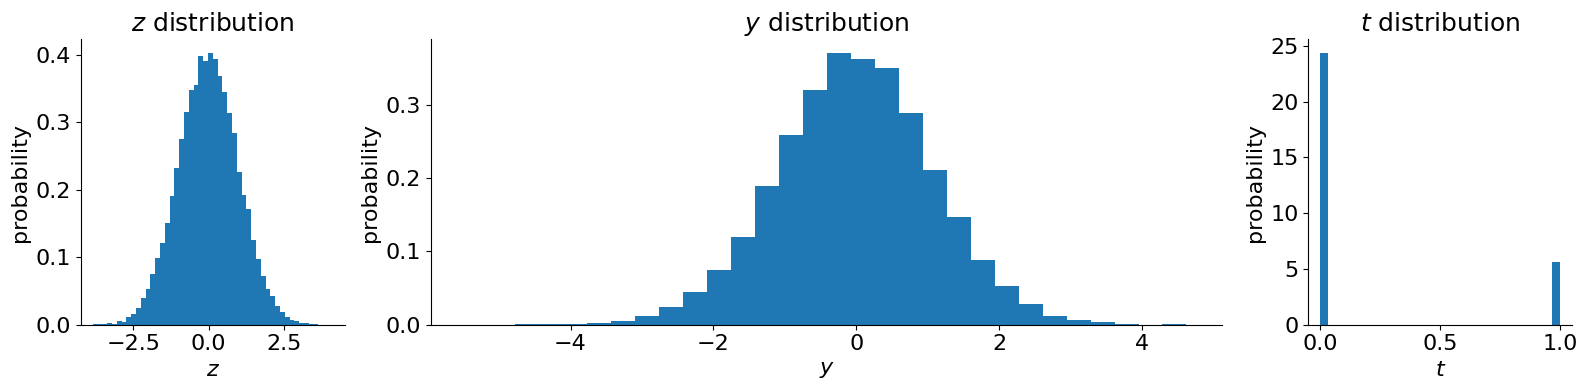

In [14]:
fig, ax = plt.subplots(1,3, figsize=(16,4),gridspec_kw={"width_ratios":[1,3,1]})


ax[0].hist(z, bins=50, density=True)
ax[0].set_title("$z$ distribution", fontsize=18)
ax[0].set_xlabel('$z$', fontsize=16)
ax[0].set_ylabel("probability", fontsize=16)
ax[0].tick_params(which='major', axis='both', labelsize=16)

ax[1].hist(y, bins=30, density=True)
ax[1].set_title("$y$ distribution", fontsize=18)
ax[1].set_xlabel('$y$', fontsize=16)
ax[1].set_ylabel("probability", fontsize=16)
ax[1].tick_params(which='major', axis='both', labelsize=16)

ax[2].hist(t, bins=30, density=True)
ax[2].set_title("$t$ distribution", fontsize=18)
ax[2].set_xlabel('$t$', fontsize=16)
ax[2].set_ylabel("probability", fontsize=16)
ax[2].tick_params(which='major', axis='both', labelsize=16)

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

### check p(y|t) 

there are 16239 samles t=0
there are 3761 samles t=1


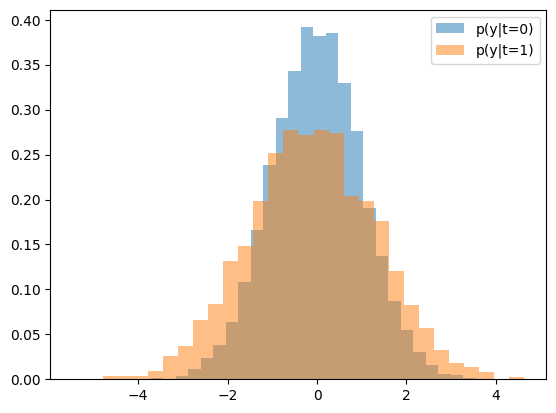

In [15]:
print(f"there are {len(y_t0)} samles t=0")
print(f"there are {len(y_t1)} samles t=1")
plt.hist(y_t0, bins=30, alpha=0.5, label='p(y|t=0)', density=True)
plt.hist(y_t1, bins=30, alpha=0.5, label='p(y|t=1)', density=True)
plt.legend(loc='upper right')
plt.show()

# Generate source domain dataset and target domain dataset

## Divided by binary covariate

In [16]:
source_data = data.loc[data['x7']==1.0]
target_data = data.loc[data['x7']==0.0]
dist_z_source = [0, 1]
dist_z_target = [0, 1]

there are 10308 samles in source domain
there are 9692 samles in target domain


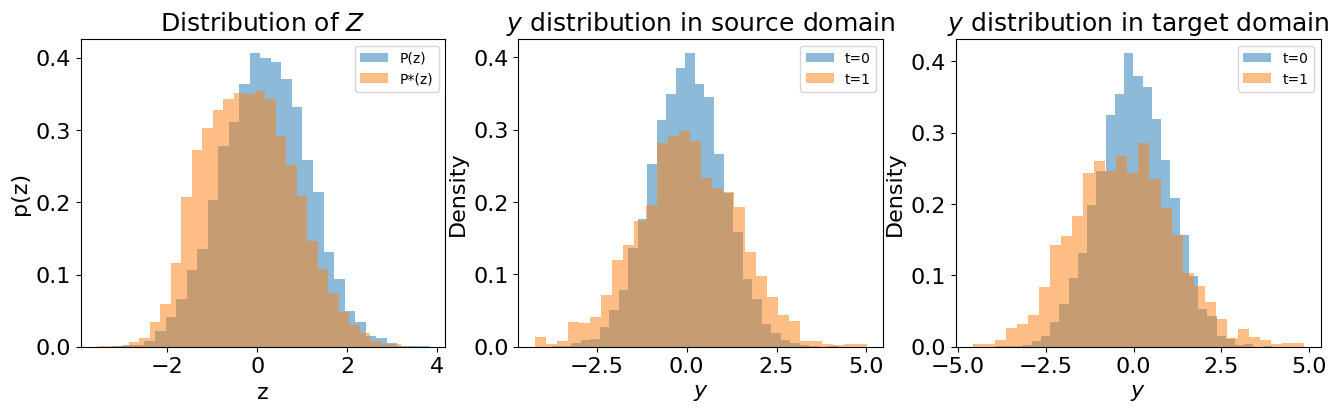

In [ ]:
print(f"there are {len(source_data)} samles in source domain")
print(f"there are {len(target_data)} samles in target domain")

#plt.legend(loc='upper right')
#plt.show()

plot_souce_target(source_data, target_data)

## Cut it by half

In [29]:
# split them into half
# sort the data by z
sorted_data = data.sort_values(by=['z'])
source_data = sorted_data.iloc[: int(len(sorted_data)/2)]
target_data = sorted_data.iloc[int(len(sorted_data)/2):]
dist_z_source = [0, 1]
dist_z_target = [0, 1]


In [ ]:
sorted_data.head()

,z,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x17,x18,x19,x20,x21,x22,x23,x24,t,y
15333,-3.926862,-2.726585,-3.938477,3.698471,0.0,-1.227143,0.982266,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.723973
11093,-3.604075,-2.717850,-3.332462,2.803056,0.0,0.938243,1.298873,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.454258
17652,-3.599210,-2.820497,-3.851410,2.859086,3.0,-0.854187,0.108455,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.684978
19516,-3.486589,-2.682178,-3.539554,2.896749,2.0,-1.170320,-0.789343,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.175976
3137,-3.471052,-2.690933,-4.102636,3.906606,3.0,-0.795868,-0.477202,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.387443


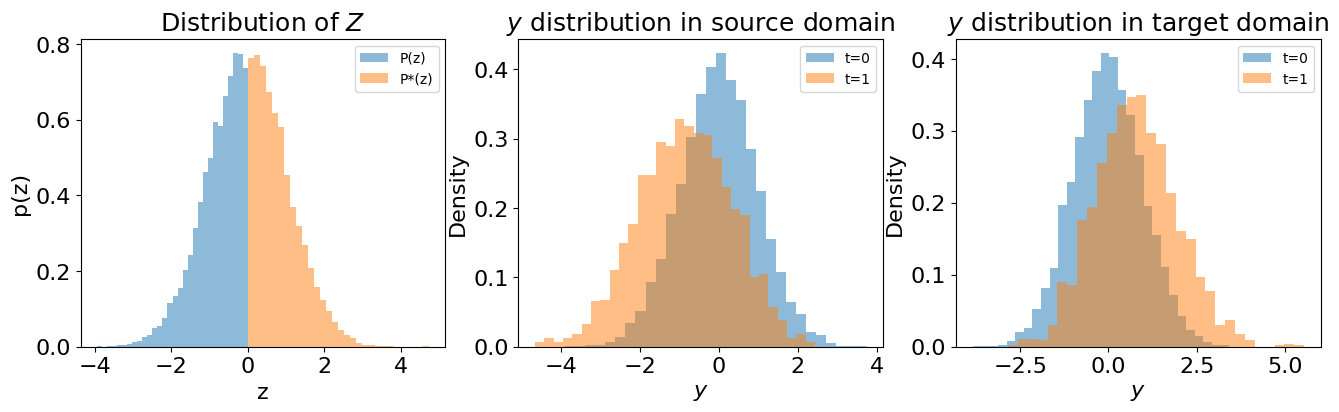

In [30]:
plot_souce_target(source_data, target_data)

## Sample two gaussians

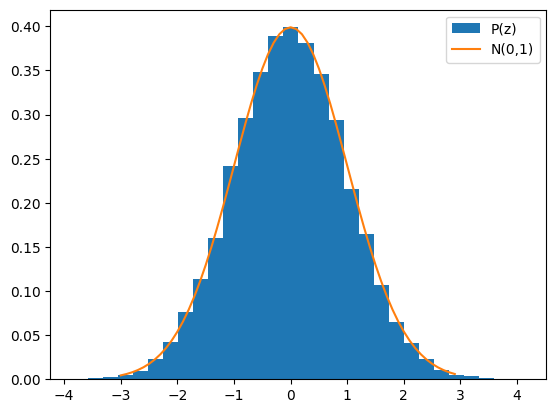

In [17]:
# check the distibution of z  

#mu, std = norm.fit(sorted_data['z']) 
x = np.arange(-3, 3, 0.1)
p = norm.pdf(x, loc=0, scale=1)

plt.hist(data['z'], bins=30, density=True, label='P(z)')
plt.plot(x, p, label='N(0,1)')
plt.legend()
plt.show()


In [18]:
# sample the target gaussian by rejection sampling
from scipy.stats import norm


dist_z_source = [-1, 1]
dist_z_target = [1, 1]
# target z distribution
def p_source(x):
    return norm.pdf(x, loc=dist_z_source[0], scale=dist_z_source[1])

def p_target(x):
    return norm.pdf(x, loc=dist_z_target[0], scale=dist_z_target[1])
    
# z distribution in the dataset
def q(x):
    return norm.pdf(x, loc=0, scale=1)

def rejection_sampling(sample, p, size):
    
    x = np.arange(-3, 3, 0.1)
    k = max(p(x)/q(x))
    c = np.random.uniform(0, 1, size=size)
    mask = p(sample) / (k * q(sample)) > c
    return mask


In [19]:

sample = np.array(data['z'])
mask_source = rejection_sampling(sample, p_source, len(data))
source_data = data[mask_source]

mask_target = rejection_sampling(sample, p_target, len(data))
target_data = data[mask_target]

there are 1679 samles in source domain
there are 1704 samles in target domain


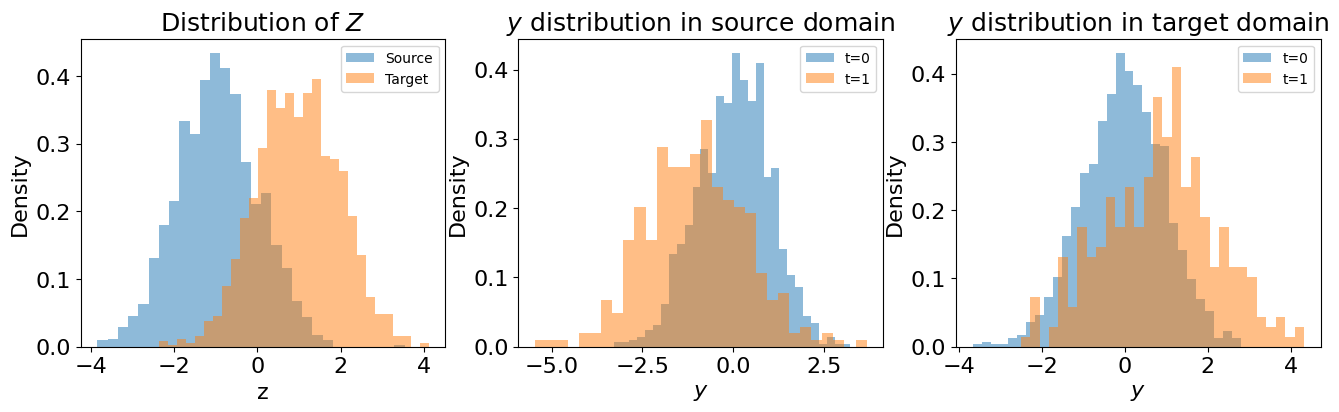

<Figure size 640x480 with 0 Axes>

In [20]:
print(f"there are {len(source_data)} samles in source domain")
print(f"there are {len(target_data)} samles in target domain")

#plt.legend(loc='upper right')
#plt.show()

plot_souce_target(source_data, target_data)

# Train on the source domain dataset

In [21]:
from models import trainZTtoYmodel, trainXTtoYmodel, trainZtoXmodel, GenericDataset, RMSE_loss

number_trained_sample = 1000
source_data = source_data.sample(number_trained_sample)



In [37]:

source_data.head()

,z,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x17,x18,x19,x20,x21,x22,x23,x24,t,y
5354,-0.576191,0.621232,0.430660,-0.791288,0.0,-0.456272,-0.411773,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164856
12764,-1.766308,1.579183,1.598987,-1.616467,1.0,-0.772770,1.249049,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.353062
17184,-1.787700,1.858357,0.328535,0.246739,0.0,1.284708,-1.005668,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.952870
8258,0.297699,-0.307596,0.555152,0.204828,0.0,-0.026260,-1.070737,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.240340
4473,-0.544753,0.509379,1.116381,0.698242,0.0,-1.179267,-0.089578,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.458248


## Pretrain a decoder using source domain data

Epoch 0:
Epoch loss: 24612.212646484375
x: 22847.486572265625, t: 0, y: 1764.7261810302734
Epoch 1:
Epoch loss: 24378.113525390625
x: 22645.273681640625, t: 0, y: 1732.8393096923828
Epoch 2:
Epoch loss: 24166.044677734375
x: 22462.74072265625, t: 0, y: 1703.3041076660156
Epoch 3:
Epoch loss: 23975.0947265625
x: 22301.148193359375, t: 0, y: 1673.9464721679688
Epoch 4:
Epoch loss: 23795.96728515625
x: 22149.254150390625, t: 0, y: 1646.7130432128906
Epoch 5:
Epoch loss: 23617.27734375
x: 21993.087646484375, t: 0, y: 1624.1896209716797
Epoch 6:
Epoch loss: 23436.125
x: 21833.88818359375, t: 0, y: 1602.2370910644531
Epoch 7:
Epoch loss: 23247.010009765625
x: 21663.660888671875, t: 0, y: 1583.3490295410156
Epoch 8:
Epoch loss: 23052.23876953125
x: 21486.28466796875, t: 0, y: 1565.9544372558594
Epoch 9:
Epoch loss: 22841.130859375
x: 21291.61181640625, t: 0, y: 1549.5186614990234
Epoch 10:
Epoch loss: 22626.575927734375
x: 21090.0322265625, t: 0, y: 1536.5436248779297
Epoch 11:
Epoch loss: 22

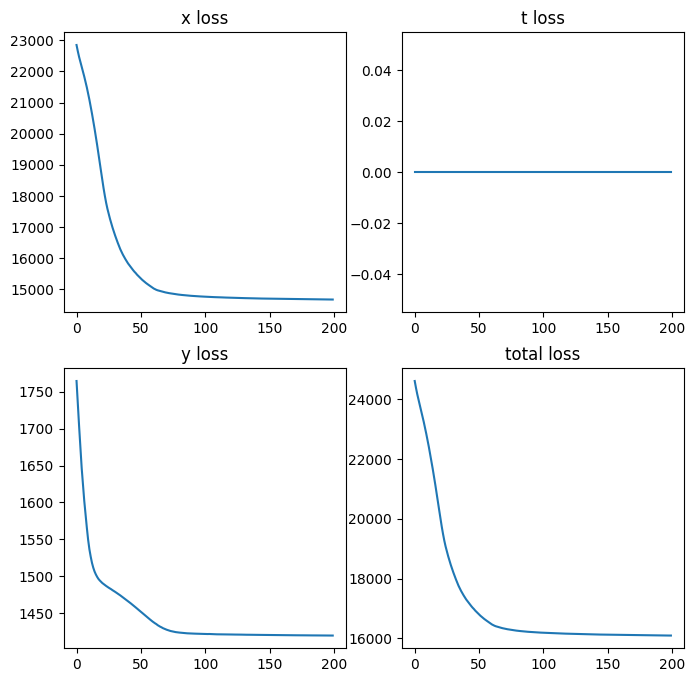

In [22]:
from models import GenericDataset, train_decoder
from torch.utils.data import DataLoader

# get the training data
dataset = GenericDataset(np.array(source_data))
dataloader = DataLoader(dataset, shuffle=True, batch_size=100)
device='cpu'
plot_curves=False
print_logs=True
num_epochs=200
lr_start=0.0002
lr_end=0.00005
x_dim=25
z_dim=1
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)
p_t_z_nn = False

decoder, losses = train_decoder(device, plot_curves, print_logs, 
                                  dataloader, num_epochs, lr_start, lr_end, 
                                  x_dim, z_dim, p_t_z_nn, p_t_z_nn_layers=3,
                                  p_t_z_nn_width=30, p_x_z_nn_layers=3, p_x_z_nn_width=30, 
                                  p_y_nn_layers =3, p_y_nn_width=30,
                                  q_z_nn_layers=3, q_z_nn_width=30,
                                  x_mode=x_mode, y_loss_type = 2, y_separate_heads=True)

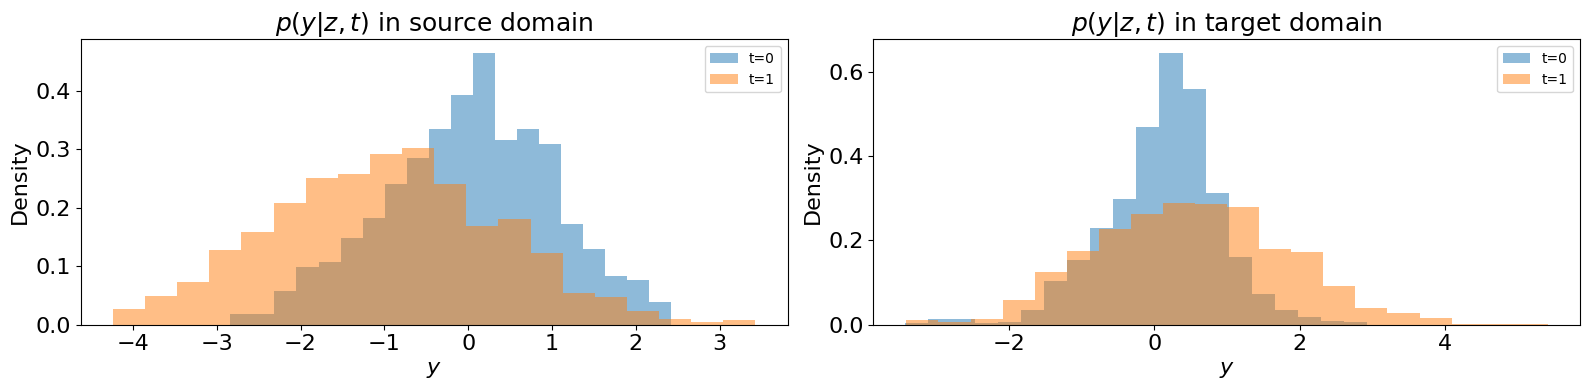

In [23]:
# test the decoder on source domain data and target domain data
plot_py_zt(source_data, target_data, decoder.y_nn, num_test_sample=1000, loss_type = 2)

## Pretrain a VAE for the proxy $X$ using source domain data

Epoch 0:
Epoch loss: 25037.11669921875
x: 23343.120361328125, t: 0, y: 1675.7776184082031, kld: 18.218935132026672
Epoch 1:
Epoch loss: 24917.953857421875
x: 23239.709228515625, t: 0, y: 1664.8630065917969, kld: 13.382277131080627
Epoch 2:
Epoch loss: 24785.967529296875
x: 23128.6025390625, t: 0, y: 1647.9438171386719, kld: 9.420978844165802
Epoch 3:
Epoch loss: 24669.6923828125
x: 23032.848876953125, t: 0, y: 1630.646011352539, kld: 6.197456210851669
Epoch 4:
Epoch loss: 24560.029541015625
x: 22934.45556640625, t: 0, y: 1621.783462524414, kld: 3.790709465742111
Epoch 5:
Epoch loss: 24426.787841796875
x: 22817.07421875, t: 0, y: 1607.3254699707031, kld: 2.3880476653575897
Epoch 6:
Epoch loss: 24283.484619140625
x: 22693.9111328125, t: 0, y: 1587.1975555419922, kld: 2.375794619321823
Epoch 7:
Epoch loss: 24120.43505859375
x: 22536.274658203125, t: 0, y: 1580.069808959961, kld: 4.090286761522293
Epoch 8:
Epoch loss: 23951.628173828125
x: 22372.62841796875, t: 0, y: 1571.1129760742188, kl

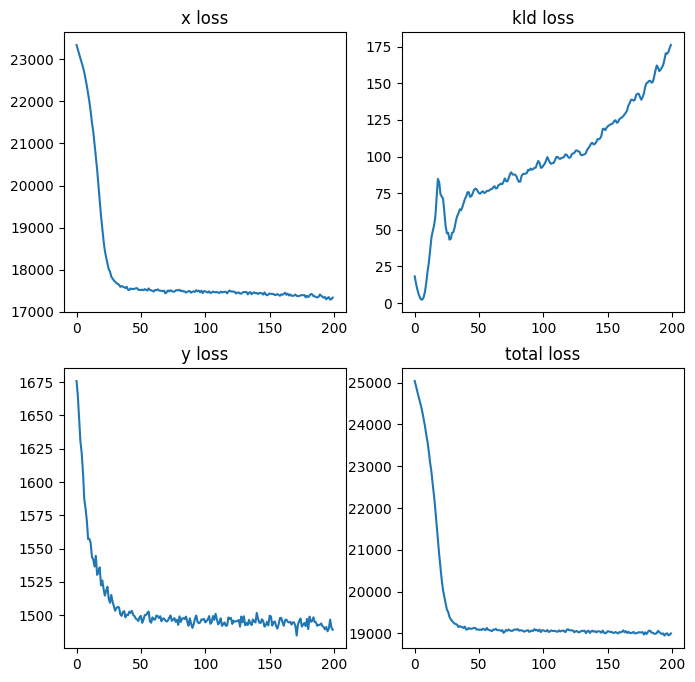

In [24]:
from models import GenericDataset, train_ProxyVAE
from torch.utils.data import DataLoader

# get the training data (exclude z)
source_proxy = np.array(source_data.iloc[:, 1:])
dataset = GenericDataset(source_proxy)
dataloader = DataLoader(dataset, shuffle=True, batch_size=100)
device='cpu'
plot_curves=False
print_logs=True
num_epochs=200
lr_start=0.0002
lr_end=0.00005
x_dim=25
z_dim=1
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)

p_t_z_nn = False

source_VAE, losses = train_ProxyVAE(device, plot_curves, print_logs, 
                                  dataloader, num_epochs, lr_start, lr_end, 
                                  x_dim, z_dim, p_t_z_nn, p_t_z_nn_layers=3,p_t_z_nn_width=30, 
                                  p_x_z_nn_layers=3, p_x_z_nn_width=30, 
                                  p_y_nn_layers =3, p_y_nn_width=30,
                                  q_z_nn_layers=3, q_z_nn_width=30,
                                  x_mode=x_mode, y_loss_type = 2, y_separate_heads=True)

# Test on the target domain dataset

In [25]:
from models import ProxyVAE
from env import eva_causal, eva_random, eva_negative
from copy import deepcopy



# seeds for the target domain running
seeds = [1,2,3,4,5]
# seed for target domain data sampling
seed = 1
np.random.seed(seed)
random.seed(seed)
N = 1000
#test_data = data.sample(N)        # target domain N(0, 1)
test_data = target_data.sample(N)

# Hyperparamer setting
beta = 0.1
vae_freq = [1000, 200, 100, 50, 25, 15, 10, 8, 6, 5]
lr = 0.005
batch_size = 32
y_separate_heads = True
update_decoder = True

total_regret_vs_vae_freq = {"Causal":[], "VAE":[], "VAE(prior)": [], "Random": [] }

for j in range(len(vae_freq)):

    reward_causal_transDe_episodes = []
    reward_causal_NoDe_episodes = []
    reward_causal_sourceVAE_episodes = []
    reward_negative_episodes = []
    reward_random_episodes = []

    regret_causal_transDe_episodes = []
    regret_causal_NoDe_episodes = []
    regret_causal_sourceVAE_episodes = []
    regret_negative_episodes = []
    regret_random_episodes = []

    for i in range(5):

        seed = seeds[i]
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)


        target_VAE = ProxyVAE(x_dim, z_dim, device, p_t_z_nn, p_t_z_nn_layers=3,p_t_z_nn_width=30, 
                          p_x_z_nn_layers=3, 
                      p_x_z_nn_width=30, p_y_zt_nn_layers = 3, p_y_zt_nn_width=30, q_z_nn_layers=3, q_z_nn_width=30, x_mode=x_mode, y_loss_type=2, y_separate_heads=y_separate_heads)
        target_VAE_transD = ProxyVAE(x_dim, z_dim, device, p_t_z_nn, p_t_z_nn_layers=3, p_t_z_nn_width=3, 
                                 p_x_z_nn_layers=3, 
                      p_x_z_nn_width=30, p_y_zt_nn_layers = 3, p_y_zt_nn_width=30, q_z_nn_layers=3, q_z_nn_width=30, x_mode=x_mode, y_loss_type=2, y_separate_heads=y_separate_heads)
        #target_VAE_transD.decoder = deepcopy(source_VAE.decoder)
        target_VAE_transD.decoder = deepcopy(decoder)
        #target_VAE_transD.encoder = deepcopy(source_VAE.encoder)
        source_vae = deepcopy(source_VAE)

        reward_causal_transDe, regret_causal_transDe, transVAE_z, true_z = eva_causal(test_data, target_VAE_transD, beta=beta, vae_freq=vae_freq[j], lr=lr, batch_size=batch_size, train = True, update_decoder=update_decoder)
        reward_causal_NoDe, regret_causal_NoDe, randomVAE_z, _ = eva_causal(test_data, target_VAE, beta=1, vae_freq=vae_freq[j], lr=lr, batch_size=batch_size, train=True)
        reward_causal_sourceVAE, regret_causal_sourceVAE, sourceVAE_z, _ = eva_causal(test_data, source_vae, beta=1, vae_freq=vae_freq[j], lr=lr, batch_size=batch_size, train=True)
        reward_random, regret_random = eva_random(test_data, N) 

        reward_causal_transDe_episodes.append(reward_causal_transDe)
        reward_causal_NoDe_episodes.append(reward_causal_NoDe)
        reward_causal_sourceVAE_episodes.append(reward_causal_sourceVAE)
        reward_random_episodes.append(reward_random)

        regret_causal_transDe_episodes.append(regret_causal_transDe)
        regret_causal_NoDe_episodes.append(regret_causal_NoDe)
        regret_causal_sourceVAE_episodes.append(regret_causal_sourceVAE)
        regret_random_episodes.append(regret_random) 
    

    total_regret_vs_vae_freq["Causal"].append(np.mean(np.array([regret_causal_transDe_episodes[i][-1] for i in range(len(seeds))])))  
    total_regret_vs_vae_freq["VAE"].append(np.mean(np.array([regret_causal_NoDe_episodes[i][-1] for i in range(len(seeds))])))
    total_regret_vs_vae_freq["VAE(prior)"].append(np.mean(np.array([regret_causal_sourceVAE_episodes[i][-1] for i in range(len(seeds))])))     
    total_regret_vs_vae_freq["Random"].append(np.mean(np.array([regret_random_episodes[i][-1] for i in range(len(seeds))])))



/Users/mingweideng/Desktop/PhD/TL/Application of Transportability on Bandit with Unobservable Confounder/code/transportability-bandit/VAE_transfer/env.py:259: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.Tensor(obs[0]).view(batch_size, vae.x_dim)


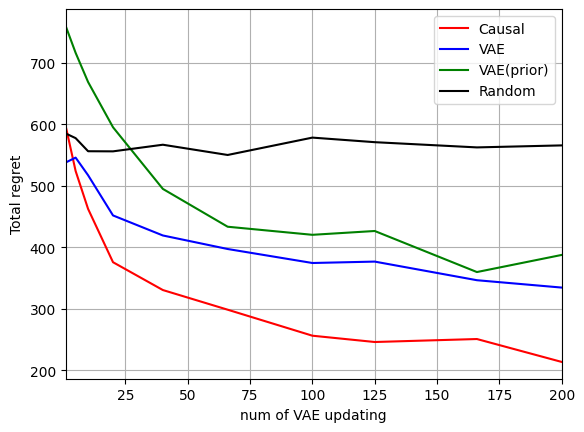

In [26]:
# ploting the regret
from plot_functions import plot_regret, plot_total_regret_vs_freq

#plot_regret(regret_causal_transDe_episodes, regret_causal_NoDe_episodes, regret_causal_sourceVAE_episodes, regret_negative_episodes, regret_random_episodes, dist_z_source=dist_z_source, dist_z_target=dist_z_target)
color_list = ['red', 'blue', 'green', 'black']
num_update = [int(1000/freq) for freq in vae_freq]
plot_total_regret_vs_freq(total_regret_vs_vae_freq, num_update, color_list)


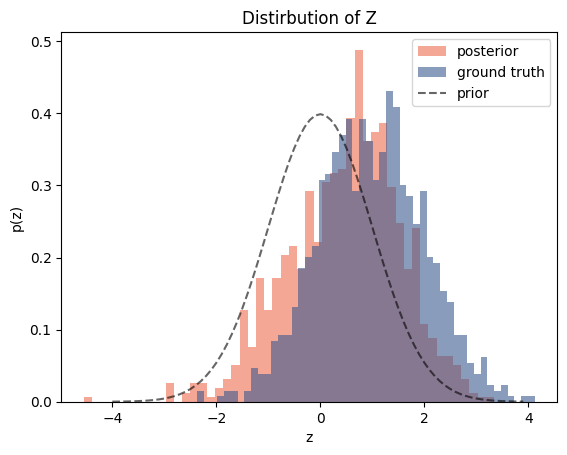

In [27]:
# ploting p(z) generated by VAE with transferred decoder
z = np.random.randn(1000)
z = [transVAE_z, true_z]
labels = ['posterior', 'ground truth']
name = 'IHDP_dist_z_'+str(dist_z_source[0])+'_'+str(dist_z_target[0])+'.tikz'
plot_z_comparasion(z, labels, name, z_index=0)